# 0. Introduction

Market traders buy and sell volatile assets frequently, with a goal to maximize their total return. If the future price of a certain asset can be forecasted more accurately, traders can take a leading position in the market.

In this project, I choose only the past stream of daily prices to date to perform time series forecasting.

## 1. Data Description

File **'BCHAIN-MKPRU.csv'** describes the five-year trading period daily prices, from 9/11/2016 to 9/10/2021.

- Date :- The date in `mm/dd/yy` (month-day-year) format.
- Value : The price in U.S. dollars of a single bitcoin on the indicated date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

raw = pd.read_csv('./data/BCHAIN-MKPRU.csv')
# Transform date into formated date type
def reproduce(ts):
    cur_ts = ts.split('/')
    new_ts = cur_ts[0] + "/" + cur_ts[1] + "/20" + cur_ts[2]
    return new_ts

raw.Date = pd.to_datetime(raw.Date.map(lambda ts: reproduce(ts)), format="%m/%d/%Y")
bitcoin = raw.set_index("Date")
bitcoin.head()

,Value
Date,
2016-09-11,621.65
2016-09-12,609.67
2016-09-13,610.92
2016-09-14,608.82
2016-09-15,610.38


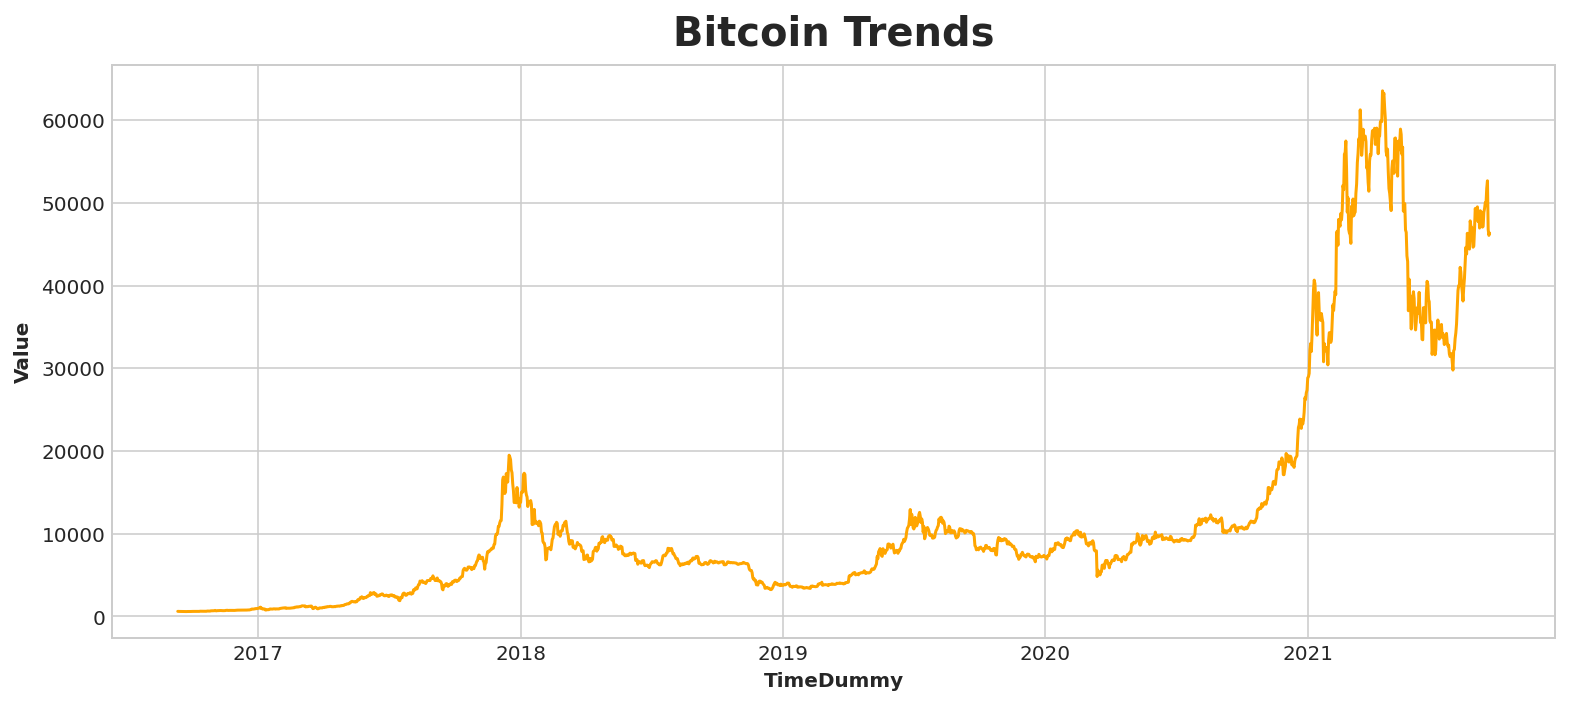

In [2]:
plt.plot(bitcoin.index,
         bitcoin.Value,
         'orange',
         label='Bitcoin Close')

plt.xlabel("TimeDummy", fontsize=10)
plt.ylabel("Value", fontsize=10)
plt.title("Bitcoin Trends", fontsize=20)
plt.show()

## 2. Data Evaluation

First we check whether we have any `nan` values

In [3]:
bitcoin.loc[bitcoin.Value.isnull()].count()

Value    0
dtype: int64

Nice! We have a well-cleansed dataset. Then we can go deep into feature engineering process

## 3. Feature Engineering

As we are trying to perform time series forecasting, we mainly focus on two kinds of features:
* Linear Features - Trends, Seasonality
* Non-linear Features - Cyclic behaviours, Lag Feature, Lead Feature

### 3.1 Trend Analysis

Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

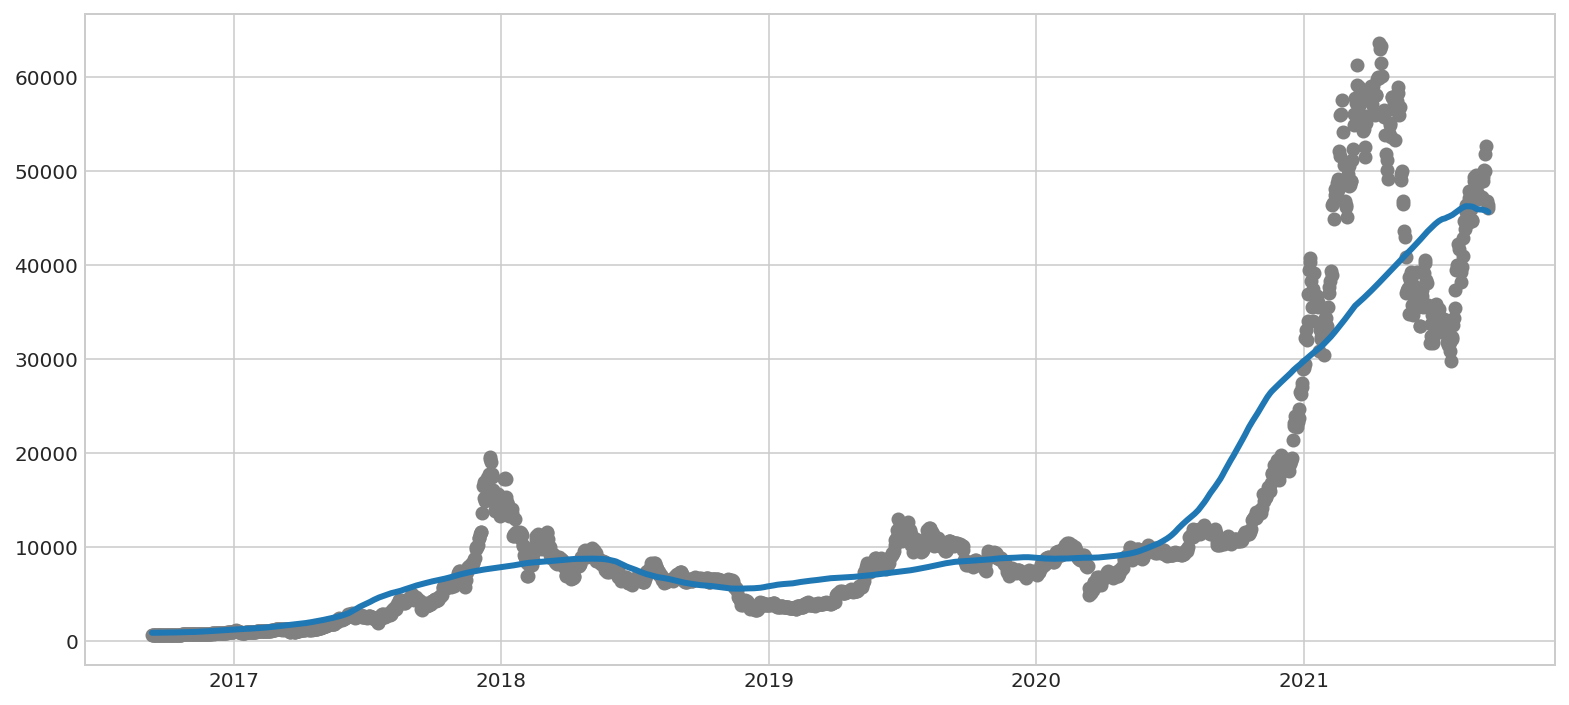

In [4]:
moving_average_365d = bitcoin.rolling(
    window=365,      # 365-day window
    center=True,     # puts the average at the center of the window
    min_periods=183  # choose about half the window size 
).mean()

plt.scatter(bitcoin.index, bitcoin.Value, color="0.5")
plt.plot(moving_average_365d.index,moving_average_365d.Value, linewidth=3)
plt.show()

### 3.2 Seasonality

In [5]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Let's take a look at seasonal plots over a week and over a year.

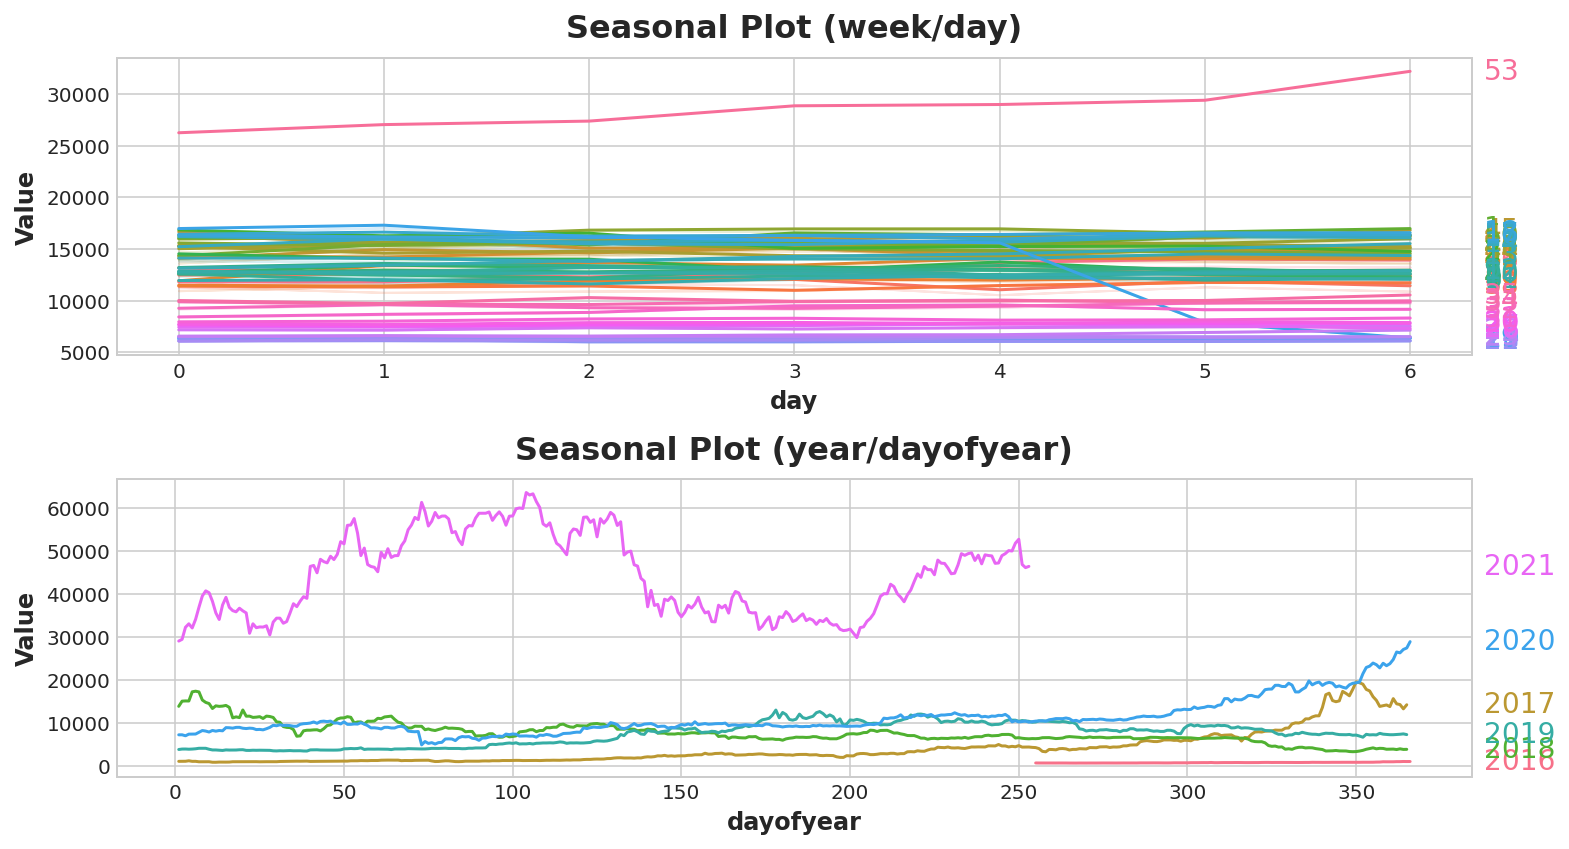

In [6]:
X = bitcoin.to_period("D").copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Value", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Value", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

/tmp/ipykernel_280426/1430787149.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(bitcoin.Value);


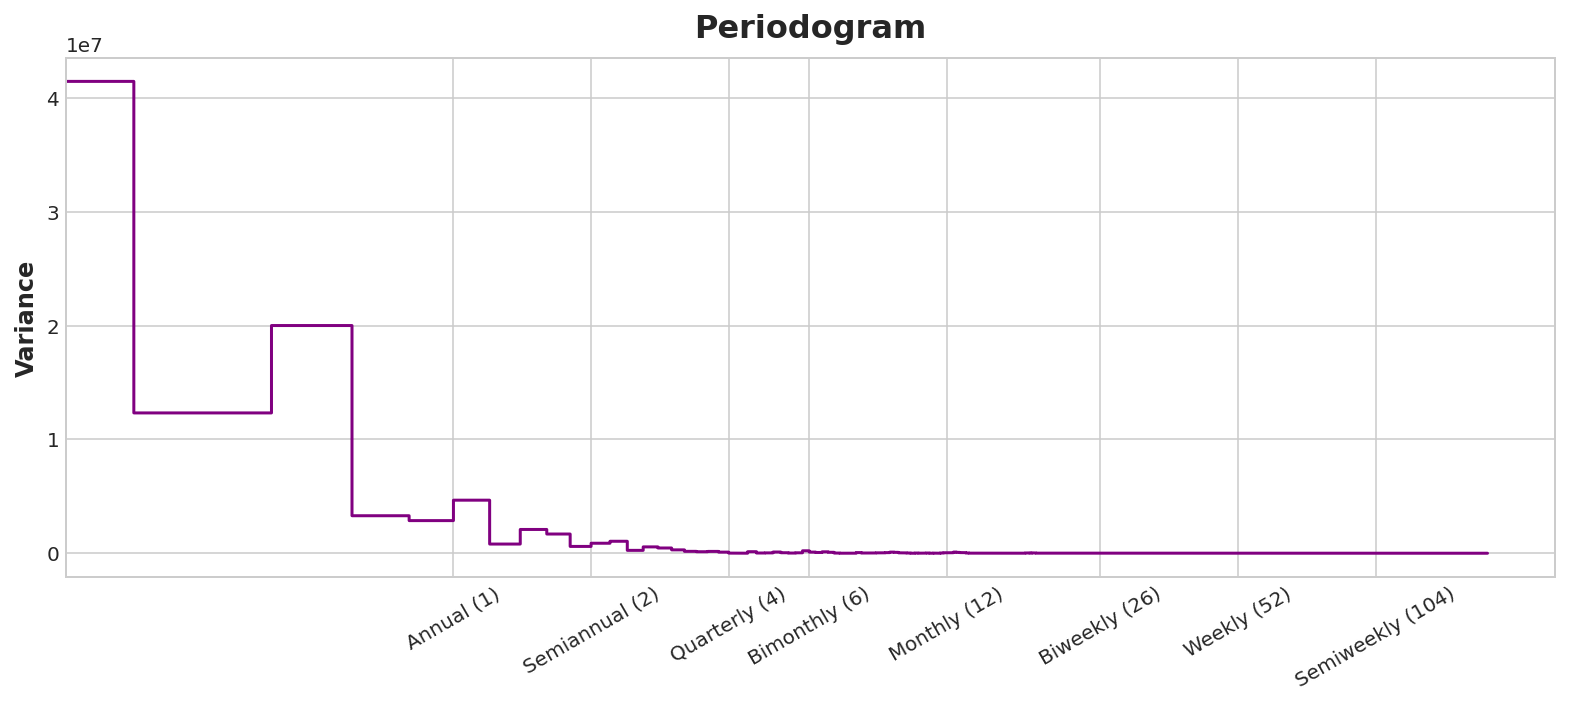

In [7]:
plot_periodogram(bitcoin.Value);

The periodogram agrees with the seasonal plots above: An unexpected sharp increasing during 2020-2021. There's not any valuable seasons in our dataset.

Thus we shall engineer our linear features of trends only.

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

y = bitcoin.copy()

dp = DeterministicProcess(
    index=y.index,
    constant=True,  # dummy feature for bias (y-intercept)
    order=1,        # trend (order 1 means linear)
)

# Create the feature set for the dates given in y.index
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

/root/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


LinearRegression()

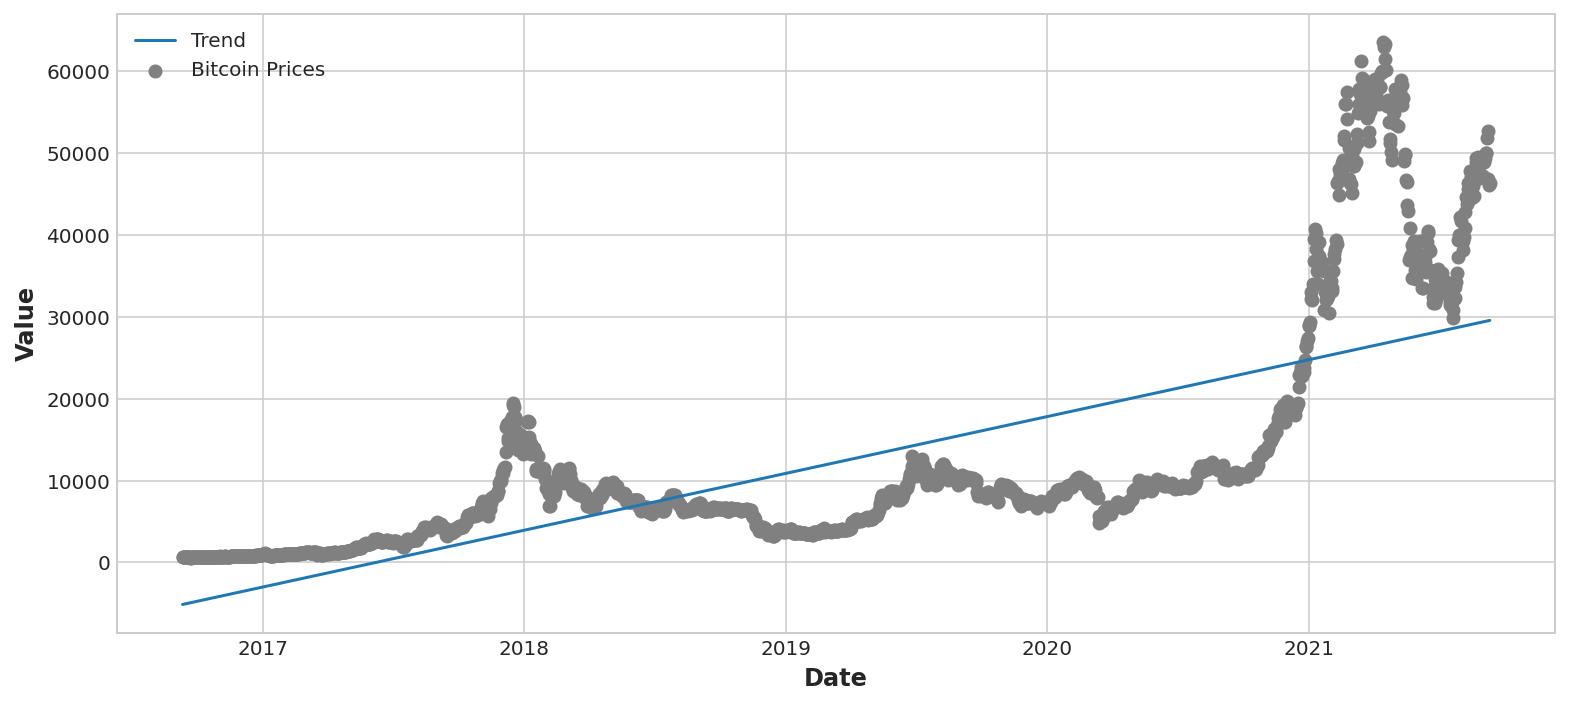

In [9]:
y_pred = model.predict(X)

plt.scatter(y.index,y,color='0.5',label="Bitcoin Prices")
plt.plot(X.index,y_pred,label="Trend")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

### 3.3 Lag Features

Now we start to identify lag features. 

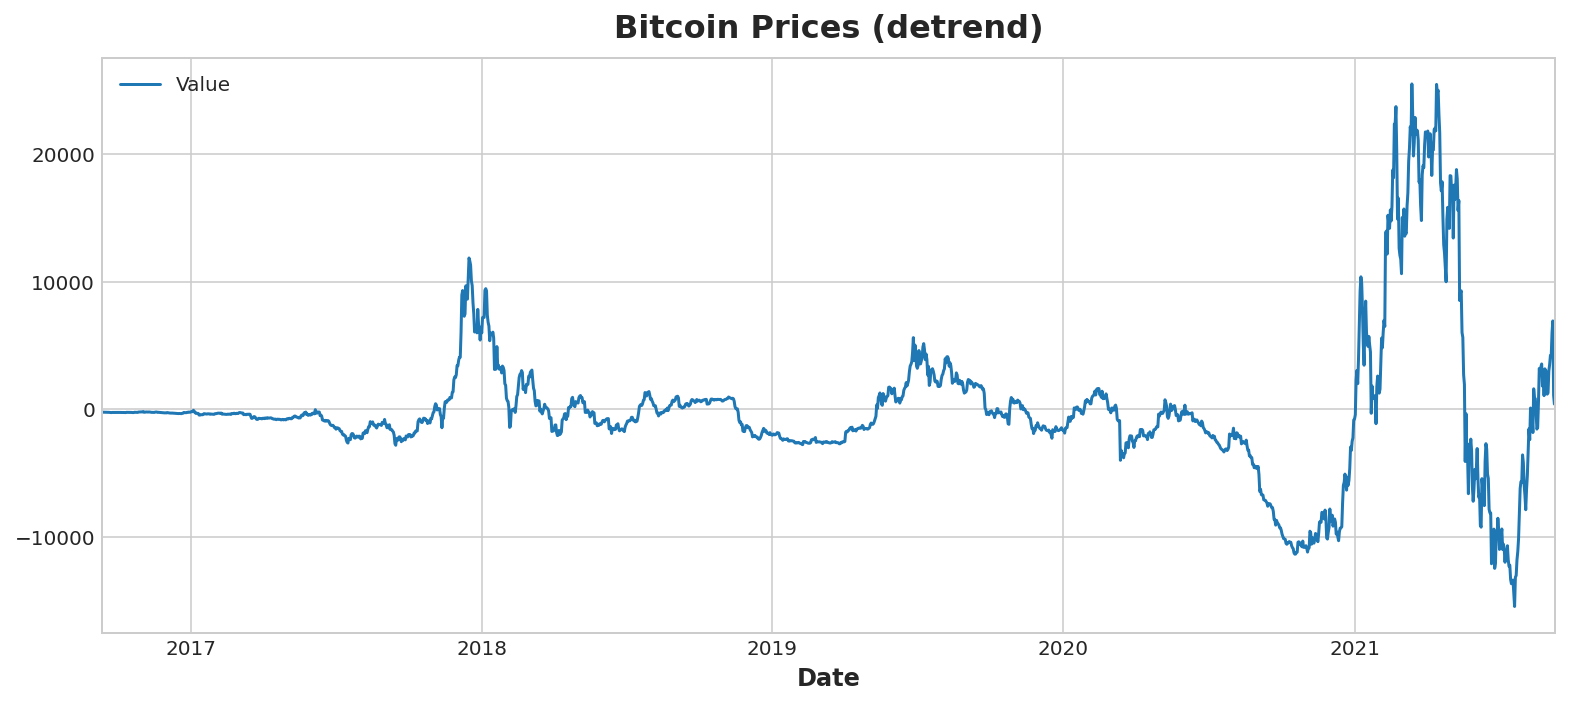

In [10]:
y_detrend = y - moving_average_365d
y_detrend.name = 'prices_detrend'

ax = y_detrend.plot()
ax.set_title("Bitcoin Prices (detrend)");

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

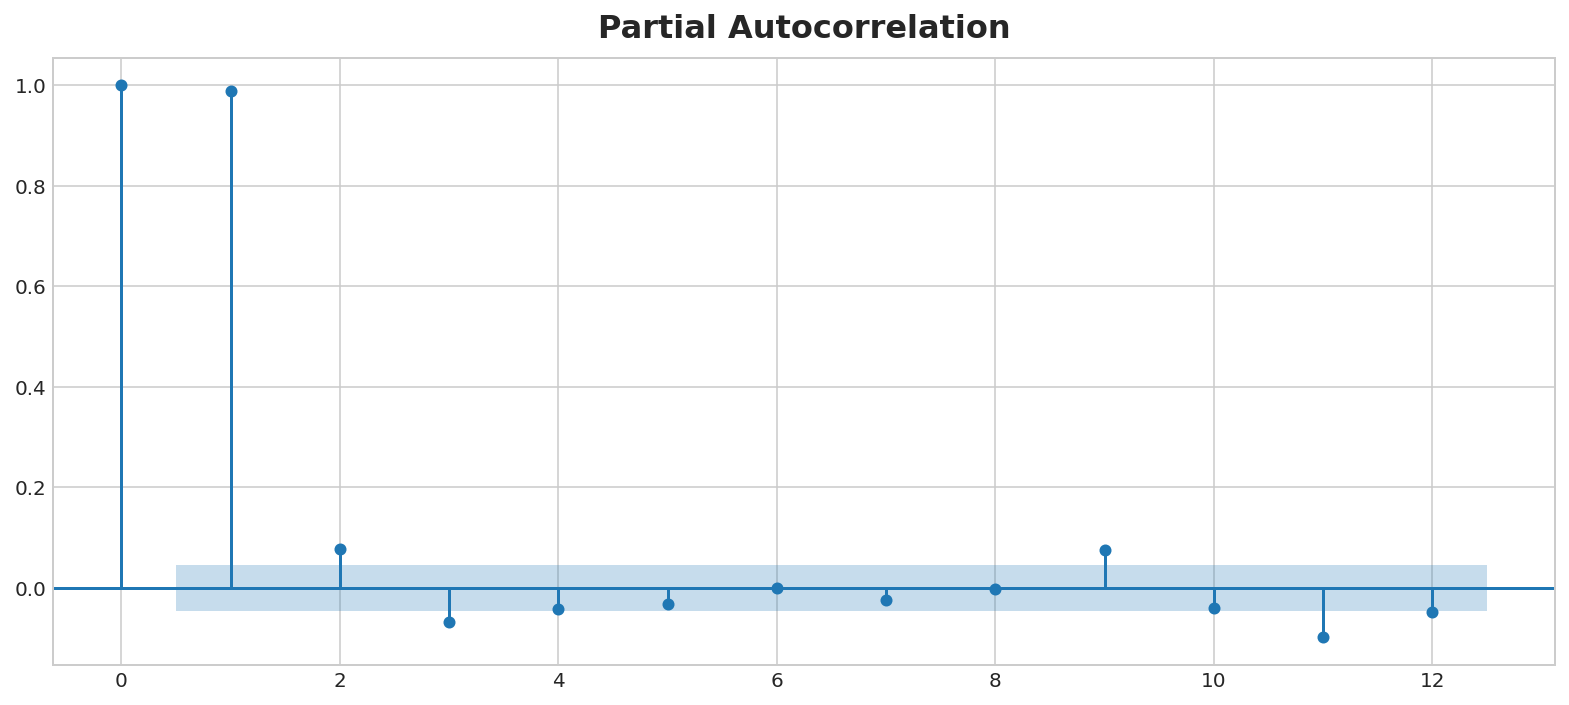

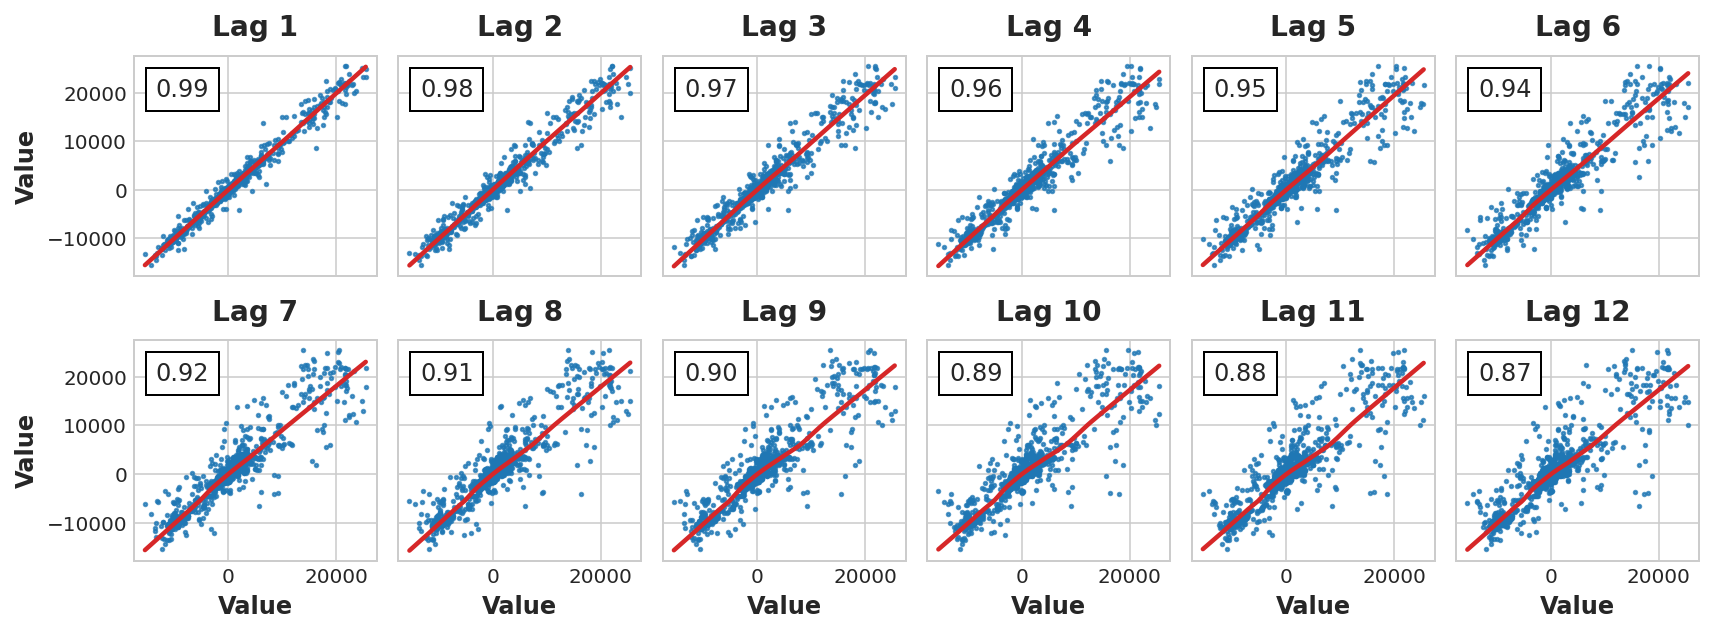

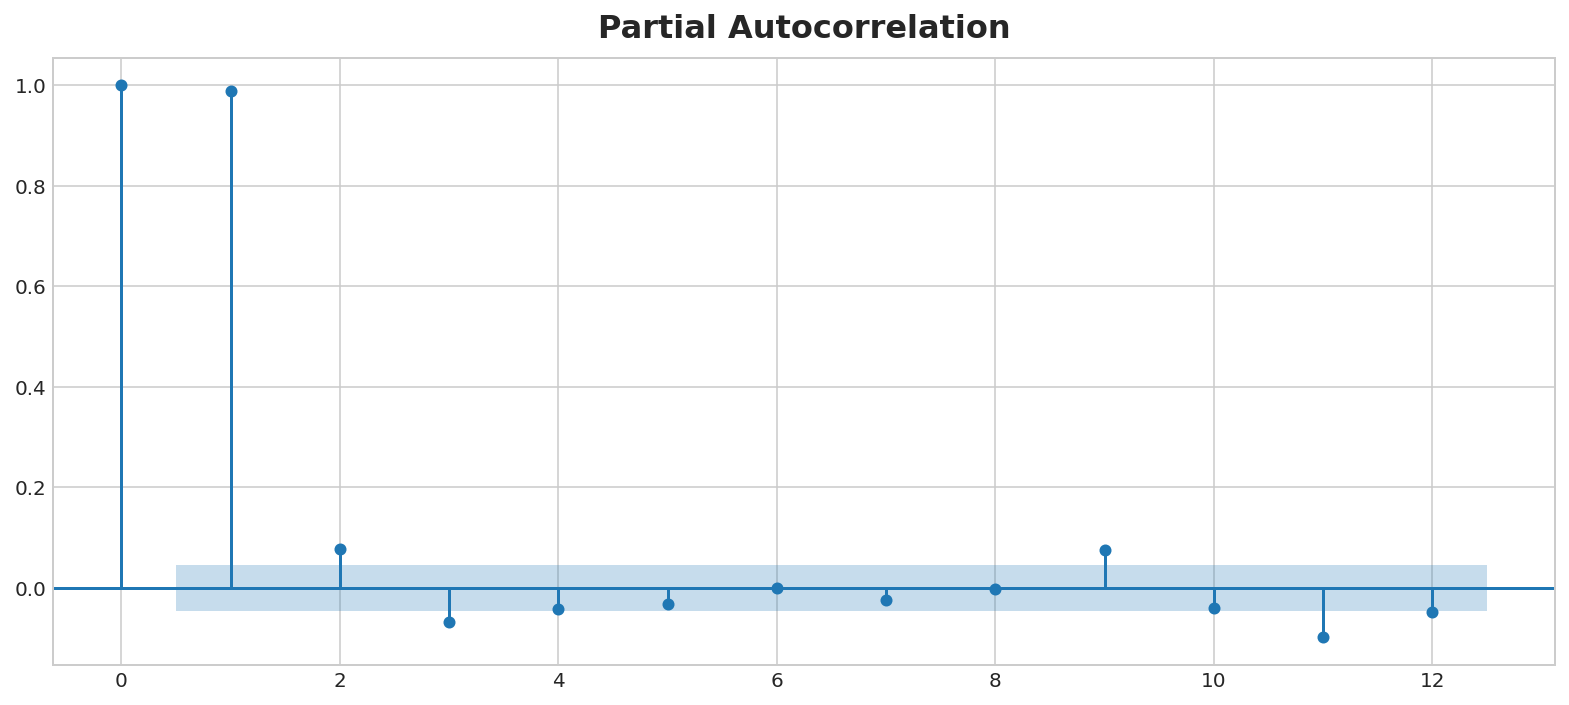

In [12]:
plot_lags(y_detrend.Value, lags=12, nrows=2)
plot_pacf(y_detrend.Value, lags=12)

The lag plots indicate that the relationship of detrended bitcoin value to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1 and 2.

In [13]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

X = make_lags(bitcoin.Value, lags=2)
X = X.fillna(0.0)

In [14]:
from sklearn.model_selection import train_test_split

# Create target series and data splits
y = bitcoin.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression(fit_intercept=True)  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train).reshape(-1,), index=y_train.index)
y_fore = pd.Series(model.predict(X_test).reshape(-1,), index=y_test.index)

Then we plot our model prediction

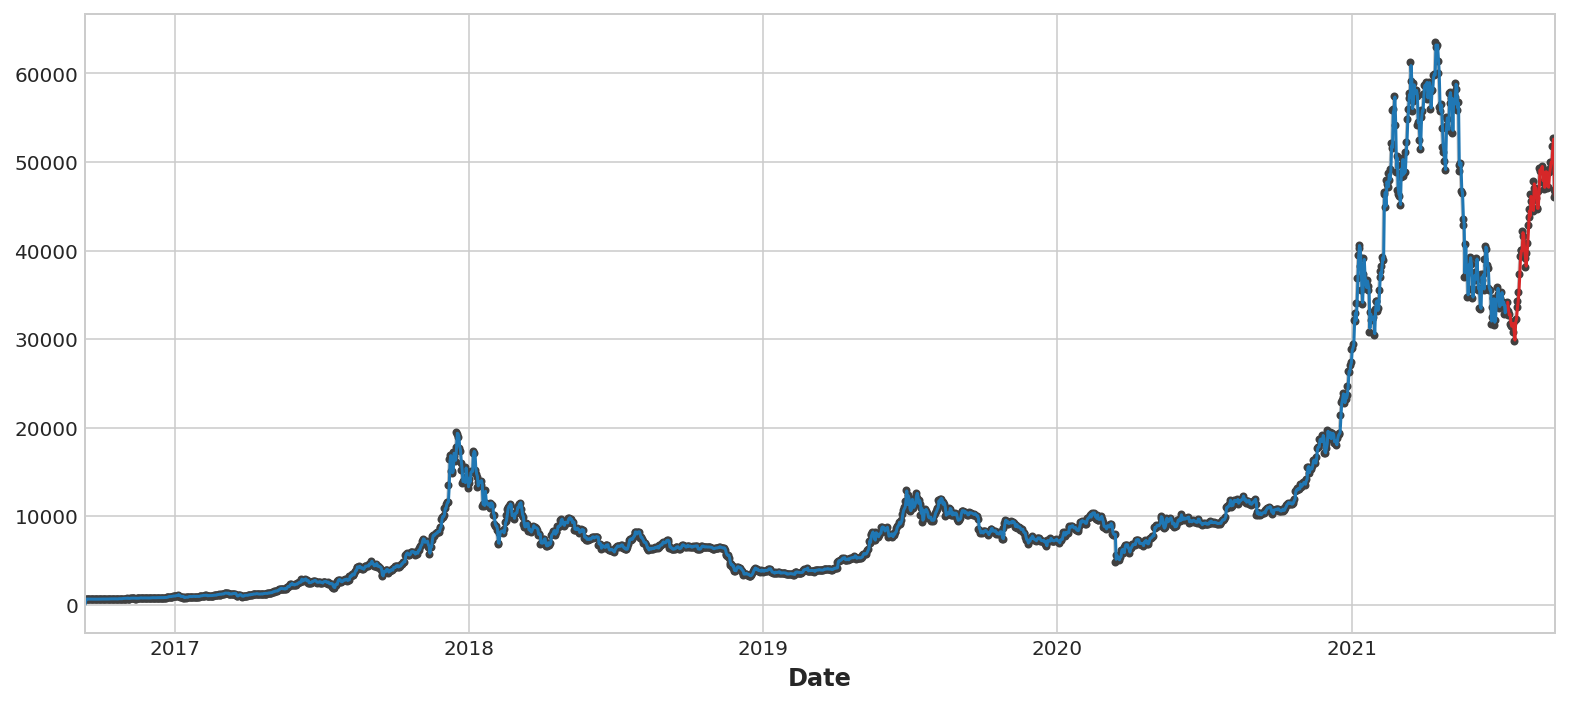

In [15]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params,ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

### 4. Hybrid Model

Now we want to combine both the linear features and non-linear features. We use 20-days moving average as trend then we use XGBoost to learn the detrendded series

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False
)

In [17]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(x_train, y_train)

# Make predictions for LinearRegression
y_fit = pd.DataFrame(
    model.predict(x_train),
    index=y_train.index,
    columns=['Value'],
)
y_pred = pd.DataFrame(
    model.predict(x_test),
    index=y_test.index,
    columns=['Value'],
)

y_resid = y_train.Value - y_fit.Value

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(x_train, y_resid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [18]:
y_train_boosted = pd.Series(xgb.predict(x_train), index=y_train.index) + y_fit.Value
y_test_boosted  = pd.Series(xgb.predict(x_test),  index=y_test.index)  + y_pred.Value

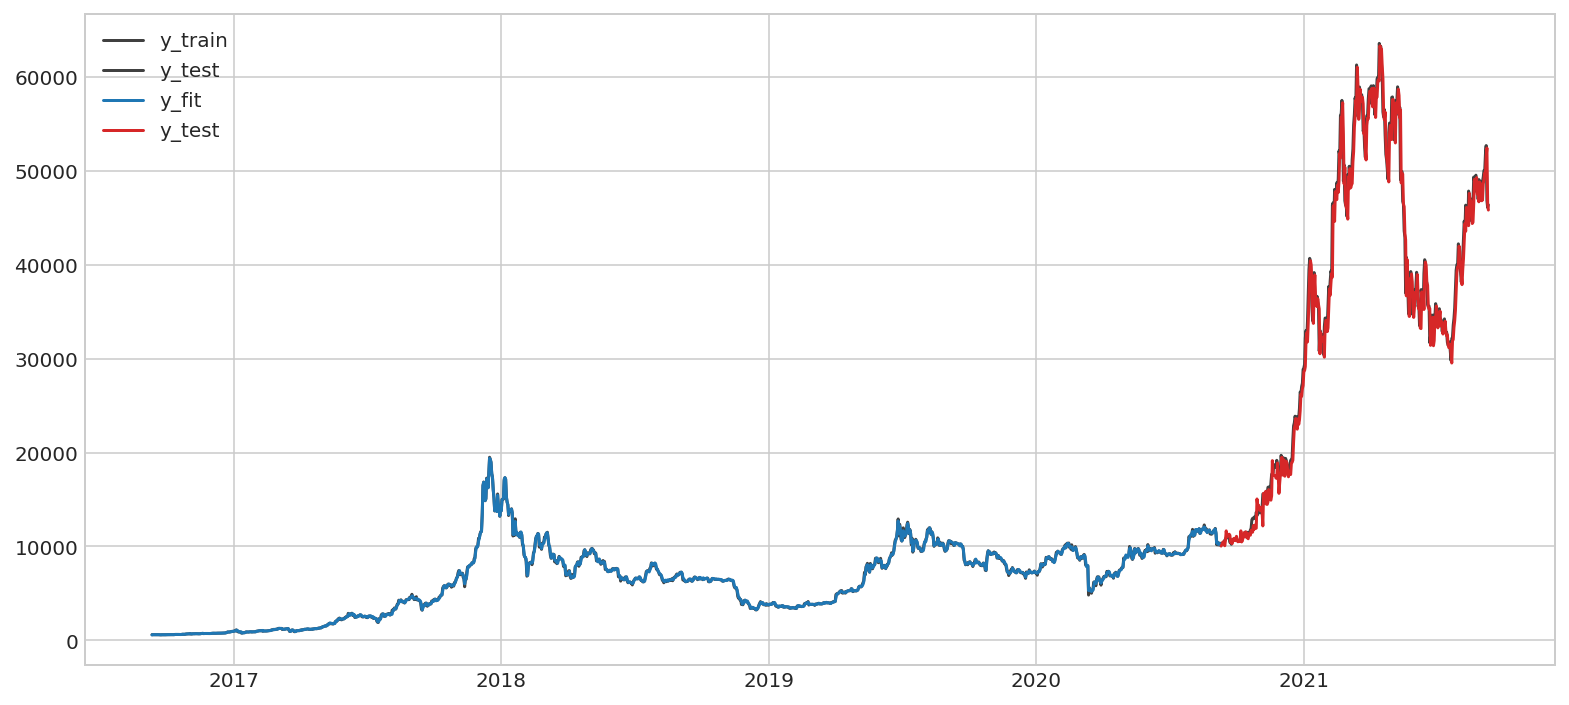

In [19]:
plt.plot(y_train.index,y_train.Value,color="0.25",label="y_train")
plt.plot(y_test.index,y_test.Value,color="0.25",label="y_test")
plt.plot(y_train_boosted.index,y_train_boosted,color="C0",label="y_fit")
plt.plot(y_test_boosted.index,y_test_boosted,color="C3",label="y_test")
plt.legend()
plt.show()

## 5. LSTM forecasting

Now we try to use `LSTM` to forecast our prices. We will use *stateful mode* as each prices are correlated.

In [20]:
# Building the LSTM
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model

2022-03-27 17:12:00.332998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-27 17:12:00.333035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
tf.compat.v1.keras.backend.set_session(
    tf.compat.v1.Session(
        config=tf.compat.v1.ConfigProto(
            intra_op_parallelism_threads=2,
            inter_op_parallelism_threads=2
        )
    )
)

2022-03-27 17:12:07.971112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 17:12:07.971516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-27 17:12:07.971544: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-27 17:12:07.971562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (slave1): /proc/driver/nvidia/version does not exist


In [22]:
from sklearn.preprocessing import MinMaxScaler

lstm_X = bitcoin.copy()
sc = MinMaxScaler(feature_range=(-1, 1))
set_scaled = sc.fit_transform(lstm_X)
set_scaled.shape

(1826, 1)

In [23]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
    return (max(train_length_values))

def get_test_length(dataset, batch_size):
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
    return (max(test_length_values))

In [24]:
batch_size = 64
epochs = 450
timesteps  = 2

# Adding timesteps * 2
# Getting train set length
trainset_len = get_train_length(set_scaled, batch_size, 0.3)
upper_train = trainset_len + timesteps * 2
lstm_training_set  = set_scaled[0:upper_train]
# Getting test set length
test_length = get_test_length(set_scaled, batch_size)
upper_test = test_length + timesteps * 2
testset_length = test_length - upper_train
lstm_test_set = lstm_X[upper_train:upper_test]
lstm_test_set_idx = lstm_X.index[upper_train:upper_test]

# construct train set
# subsetting
lstm_X_train = []
lstm_y_train = []

# Creating a data structure with n timesteps
for i in range(timesteps,trainset_len + timesteps): 
    lstm_X_train.append(lstm_training_set[i-timesteps:i,0])
    lstm_y_train.append(lstm_training_set[i:i+timesteps,0])

# Reshaping
lstm_X_train, lstm_y_train = np.array(lstm_X_train), np.array(lstm_y_train)
lstm_X_train = np.reshape(lstm_X_train,
                         (lstm_X_train.shape[0], lstm_X_train.shape[1], 1))
lstm_y_train = np.reshape(lstm_y_train,
                         (lstm_y_train.shape[0], lstm_y_train.shape[1], 1))

# construct test set
# subsetting
# scaling
lstm_scaled_test = sc.transform(np.float64(lstm_test_set))

# creating input data
lstm_X_test = []
for i in range(timesteps, testset_length + timesteps):
    lstm_X_test.append(lstm_scaled_test[i-timesteps:i, 0])

lstm_X_test = np.array(lstm_X_test)

# reshaping
lstm_X_test = np.reshape(lstm_X_test,
                         (lstm_X_test.shape[0], lstm_X_test.shape[1], 1))
lstm_X_test_idx = lstm_test_set_idx[:lstm_X_test.shape[0]]

In [88]:
# Building LSTM model
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API
inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae   = LSTM(12, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae   = LSTM(12, stateful=True, return_sequences=True)(lstm_1_mae)
output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# adam is fast starting off and then gets slower and more precise
# mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(64, 2, 1)]              0         
                                                                 
 lstm_32 (LSTM)              (64, 2, 12)               672       
                                                                 
 lstm_33 (LSTM)              (64, 2, 12)               1200      
                                                                 
 dense_16 (Dense)            (64, 2, 1)                13        
                                                                 
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Statefull Training
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(lstm_X_train, lstm_y_train,
                      shuffle=False,
                      epochs=1,
                      batch_size=batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()

#save model
# import h5py
# regressor_mae.save(filepath="./lstm_mae.h5")

Epoch: 0
19/19 [==============================] - 2s 3ms/step - loss: 0.5382
Epoch: 1
19/19 [==============================] - 0s 3ms/step - loss: 0.2369
Epoch: 2
19/19 [==============================] - 0s 3ms/step - loss: 0.1857
Epoch: 3
19/19 [==============================] - 0s 3ms/step - loss: 0.1745
Epoch: 4
19/19 [==============================] - 0s 3ms/step - loss: 0.1750
Epoch: 5
19/19 [==============================] - 0s 3ms/step - loss: 0.1688
Epoch: 6
19/19 [==============================] - 0s 3ms/step - loss: 0.1679
Epoch: 7
19/19 [==============================] - 0s 3ms/step - loss: 0.1621
Epoch: 8
19/19 [==============================] - 0s 3ms/step - loss: 0.1613
Epoch: 9
19/19 [==============================] - 0s 3ms/step - loss: 0.1564
Epoch: 10
19/19 [==============================] - 0s 3ms/step - loss: 0.1554
Epoch: 11
19/19 [==============================] - 0s 3ms/step - loss: 0.1486
Epoch: 12
19/19 [==============================] - 0s 3ms/step - loss: 0.1

In [25]:
import h5py
#load model
regressor_mae = tf.keras.models.load_model('./lstm_mae.h5')
#prediction
pred_test_mae = regressor_mae.predict(lstm_X_test, batch_size=batch_size)
regressor_mae.reset_states()

#reshaping
pred_test_mae = np.reshape(pred_test_mae, 
                           (pred_test_mae.shape[0], 
                            pred_test_mae.shape[1]))

#inverse transform
pred_test_mae = sc.inverse_transform(pred_test_mae)

#creating pred_test data
pred_test = []
for j in range(0, testset_length):
    pred_test = np.append(pred_test, pred_test_mae[j, timesteps-1])

# reshaping
pred_test = np.reshape(pred_test, (pred_test.shape[0], 1))
lstm_test_mae = pd.Series(pred_test.reshape(-1,), index=lstm_X_test_idx)

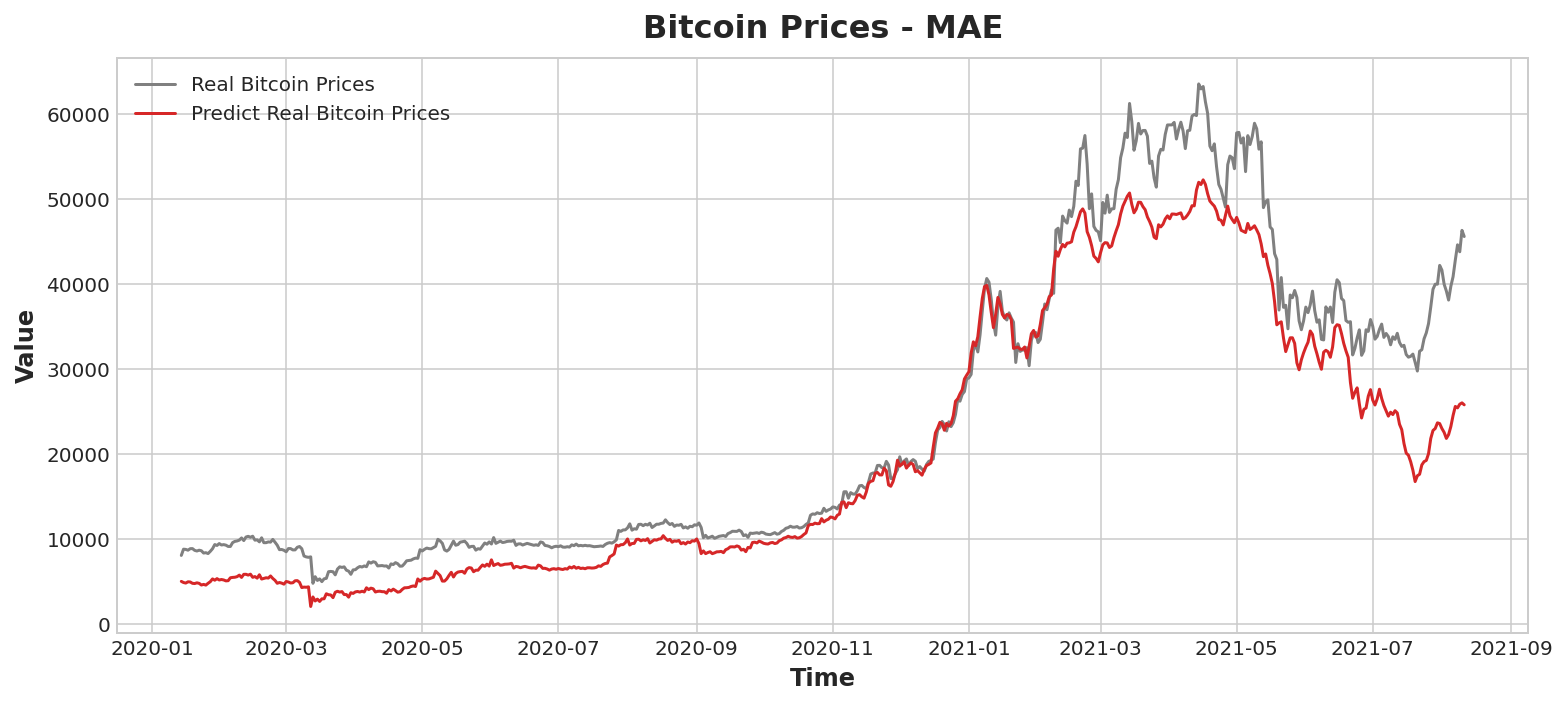

In [26]:
plt.plot(lstm_test_set.loc[lstm_X_test_idx],
         color = '0.5',
         label = 'Real Bitcoin Prices')
plt.plot(lstm_test_mae,
         color = 'C3',
         label = 'Predict Real Bitcoin Prices')
plt.title('Bitcoin Prices - MAE')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [27]:
batch_size = 64
epochs = 400
timesteps  = 2

# Adding timesteps * 2
# Getting train set length
trainset_len = get_train_length(set_scaled, batch_size, 0.3)
upper_train = trainset_len + timesteps * 2
lstm_training_set  = set_scaled[0:upper_train]
# Getting test set length
test_length = get_test_length(set_scaled, batch_size)
upper_test = test_length + timesteps * 2
testset_length = test_length - upper_train
lstm_test_set = lstm_X[upper_train:upper_test]
lstm_test_set_idx = lstm_X.index[upper_train:upper_test]

# construct train set
# subsetting
lstm_X_train = []
lstm_y_train = []

# Creating a data structure with n timesteps
for i in range(timesteps,trainset_len + timesteps): 
    lstm_X_train.append(lstm_training_set[i-timesteps:i,0])
    lstm_y_train.append(lstm_training_set[i:i+timesteps,0])

# Reshaping
lstm_X_train, lstm_y_train = np.array(lstm_X_train), np.array(lstm_y_train)
lstm_X_train = np.reshape(lstm_X_train,
                         (lstm_X_train.shape[0], lstm_X_train.shape[1], 1))
lstm_y_train = np.reshape(lstm_y_train,
                         (lstm_y_train.shape[0], lstm_y_train.shape[1], 1))

# construct test set
# subsetting
# scaling
lstm_scaled_test = sc.transform(np.float64(lstm_test_set))

# creating input data
lstm_X_test = []
for i in range(timesteps, testset_length + timesteps):
    lstm_X_test.append(lstm_scaled_test[i-timesteps:i, 0])

lstm_X_test = np.array(lstm_X_test)

# reshaping
lstm_X_test = np.reshape(lstm_X_test,
                         (lstm_X_test.shape[0], lstm_X_test.shape[1], 1))
lstm_X_test_idx = lstm_test_set_idx[:lstm_X_test.shape[0]]

In [123]:
# Building LSTM model
# Initialising the LSTM Model with MSE Loss-Function
# Using Functional API
inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse   = LSTM(12, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse   = LSTM(12, stateful=True, return_sequences=True)(lstm_1_mse)
output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

# adam is fast starting off and then gets slower and more precise
# mse -> mean square error loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(64, 2, 1)]              0         
                                                                 
 lstm_46 (LSTM)              (64, 2, 12)               672       
                                                                 
 lstm_47 (LSTM)              (64, 2, 12)               1200      
                                                                 
 dense_23 (Dense)            (64, 2, 1)                13        
                                                                 
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Statefull Training
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mse.fit(lstm_X_train, lstm_y_train,
                      shuffle=False,
                      epochs=1,
                      batch_size=batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mse.reset_states()

#save model
# regressor_mse.save(filepath="./lstm_mse.h5")

Epoch: 0
19/19 [==============================] - 3s 3ms/step - loss: 0.4366
Epoch: 1
19/19 [==============================] - 0s 3ms/step - loss: 0.1390
Epoch: 2
19/19 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch: 3
19/19 [==============================] - 0s 3ms/step - loss: 0.0816
Epoch: 4
19/19 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch: 5
19/19 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch: 6
19/19 [==============================] - 0s 3ms/step - loss: 0.0601
Epoch: 7
19/19 [==============================] - 0s 3ms/step - loss: 0.0551
Epoch: 8
19/19 [==============================] - 0s 3ms/step - loss: 0.0514
Epoch: 9
19/19 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch: 10
19/19 [==============================] - 0s 3ms/step - loss: 0.0453
Epoch: 11
19/19 [==============================] - 0s 3ms/step - loss: 0.0424
Epoch: 12
19/19 [==============================] - 0s 3ms/step - loss: 0.0

In [28]:
#load model
regressor_mse = tf.keras.models.load_model('./lstm_mse.h5')
#prediction
pred_test_mse = regressor_mse.predict(lstm_X_test, batch_size=batch_size)
regressor_mse.reset_states()

#reshaping
pred_test_mse = np.reshape(pred_test_mse, 
                           (pred_test_mse.shape[0], 
                            pred_test_mse.shape[1]))
#inverse transform
pred_test_mse = sc.inverse_transform(pred_test_mse)

#creating pred_test data
pred_test = []
for j in range(0, testset_length):
    pred_test = np.append(pred_test, pred_test_mse[j, timesteps-1])

# reshaping
pred_test = np.reshape(pred_test, (pred_test.shape[0], 1))
lstm_test_mse = pd.Series(pred_test.reshape(-1,), index=lstm_X_test_idx)

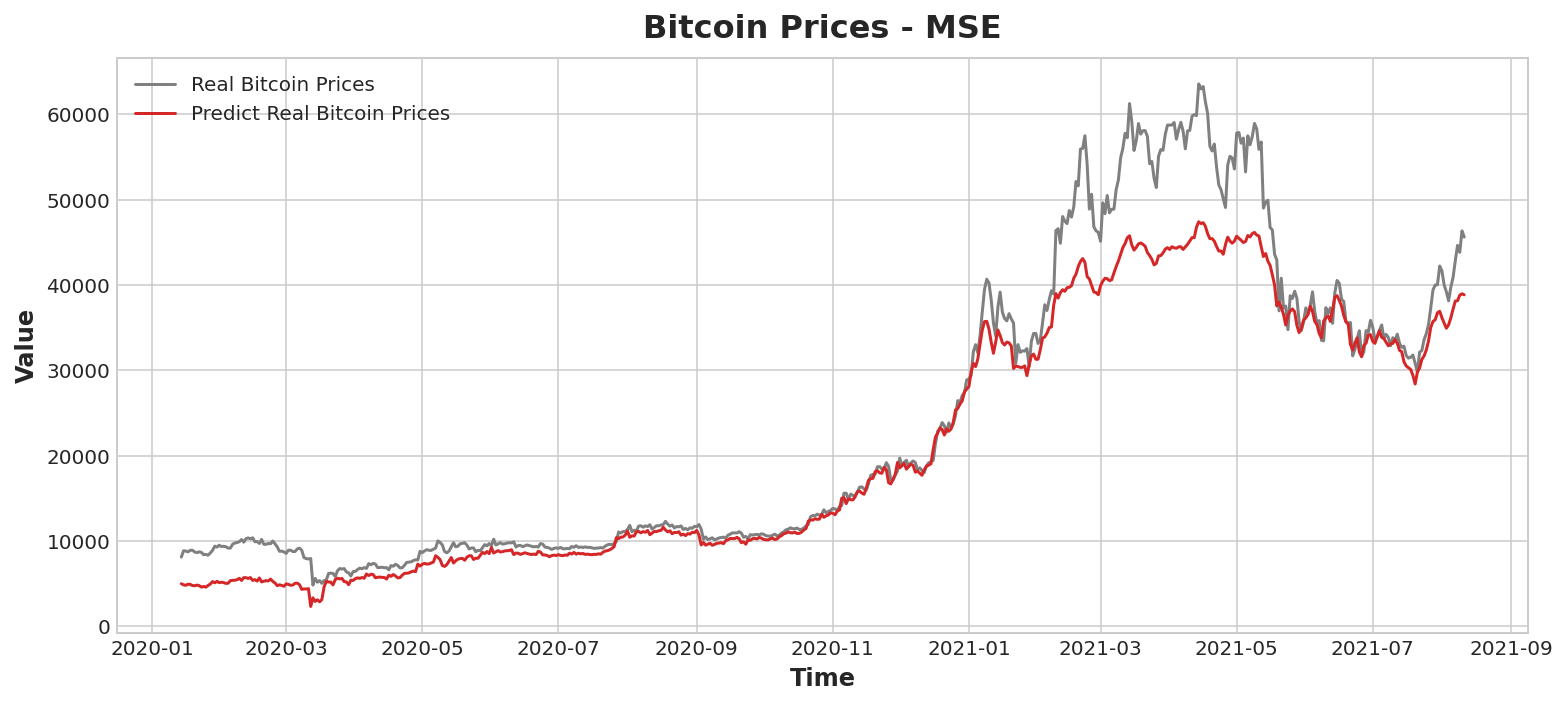

In [29]:
plt.plot(lstm_test_set.loc[lstm_X_test_idx],
         color = '0.5',
         label = 'Real Bitcoin Prices')
plt.plot(lstm_test_mse,
         color = 'C3',
         label = 'Predict Real Bitcoin Prices')
plt.title('Bitcoin Prices - MSE')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 6. Model Evaluation

Finally, we come to the last part - Evaluating our models!

In [30]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def metrics_cal(test_set, pred_set):
    rmsle,mse,mae = [
        mean_squared_log_error(test_set, pred_set) ** 0.5,
        mean_squared_error(test_set, pred_set),
        mean_absolute_error(test_set, pred_set)
    ]
    return rmsle,mse,mae

In [80]:
evaluations = dict()
evaluations['hybrid'] = metrics_cal(y_test, y_test_boosted)
evaluations['lstm_mae'] = metrics_cal(lstm_test_set.loc[lstm_X_test_idx],
                                      lstm_test_mae)
evaluations['lstm_mse'] = metrics_cal(lstm_test_set.loc[lstm_X_test_idx],
                                      lstm_test_mse)

In [99]:
eval_df = pd.DataFrame(evaluations, index=['rmsle','mse','mae']) \
    .stack() \
    .unstack(level=0)
eval_df = eval_df.reset_index()
eval_df['model'] = eval_df['index']
eval_df = eval_df.drop(['index'], axis=1)
eval_df

,rmsle,mse,mae,model
0,0.050275,3.028455e+06,1237.980185,hybrid
1,0.333268,3.097197e+07,4079.390755,lstm_mae
2,0.237922,2.509688e+07,3127.170876,lstm_mse


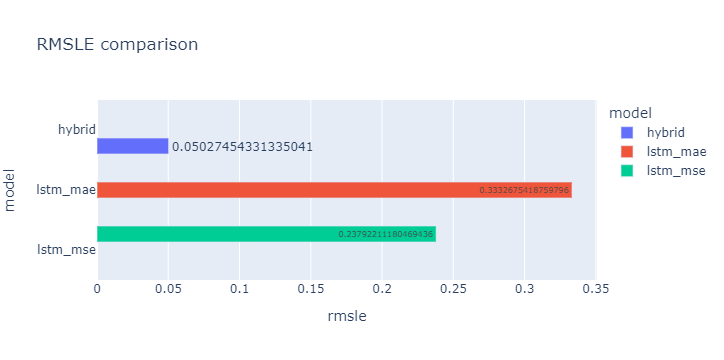

In [106]:
import plotly
import plotly.express as px
import plotly.io as pio

rmsle_fig = px.bar(
    data_frame=eval_df,
    orientation='h',
    y='model',
    x='rmsle',
    color='model',
    text='rmsle',
    title="RMSLE comparison"
)
rmsle_fig.update_layout(barmode='group')
rmsle_fig.show()

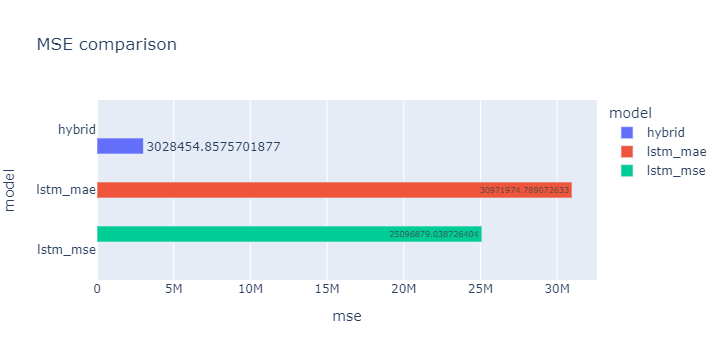

In [107]:
mse_fig = px.bar(
    data_frame=eval_df,
    orientation='h',
    y='model',
    x='mse',
    color='model',
    text='mse',
    title="MSE comparison"
)
mse_fig.update_layout(barmode='group')
mse_fig.show()

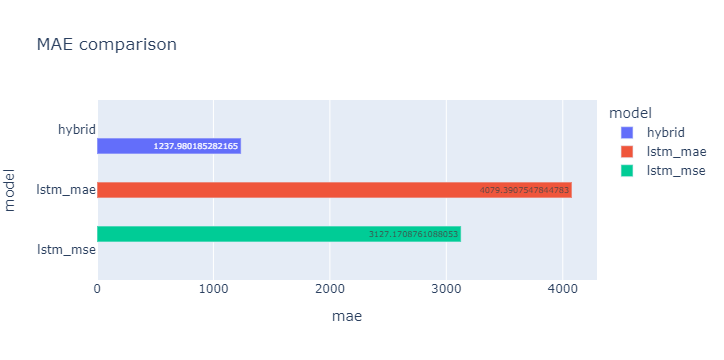

In [108]:
mae_fig = px.bar(
    data_frame=eval_df,
    orientation='h',
    y='model',
    x='mae',
    color='model',
    text='mae',
    title="MAE comparison"
)
mae_fig.update_layout(barmode='group')
mae_fig.show()